#Import Library

In [7]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import tensorflow as tf
import os
import shutil
import pickle
from google.colab import files 
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D  
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import tensorflow_addons as tfa
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation
from keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from PIL import Image
import cv2
from tensorflow.keras.applications import ResNet50
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

from skimage import io
from skimage.transform import resize

#Init Program

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Unzip Dataset

In [ ]:
! unzip '/content/drive/MyDrive/Capstone/Tomato/tomato-train-preprocess3.zip' -d . 

unzip:  cannot find or open /content/drive/MyDrive/Capstone/Tomato/tomato-train-preprocess3.zip, /content/drive/MyDrive/Capstone/Tomato/tomato-train-preprocess3.zip.zip or /content/drive/MyDrive/Capstone/Tomato/tomato-train-preprocess3.zip.ZIP.


#Support Function

In [ ]:
from tensorflow.keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.95:
            print("Validation accuracy reached 0.95 or higher. Stopping training.")
            self.model.stop_training = True

In [ ]:
def callbacks(filename):
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.3,
                          patience = 3,
                          min_lr = 1e-6,
                          mode = 'min',
                          verbose = 1)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  stop_training_callback = StopTrainingCallback()

  return [es, mc, reduce_lr, stop_training_callback]

In [ ]:
def predict_new_data(model, shape, path):
  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())

  img = load_img(path, target_size=shape)
  imgplot = plt.imshow(img)
  target = img_to_array(img)
  target = np.expand_dims(target, axis=0)
  target = np.vstack([target])
  target /= 255
  pred = model.predict(target)
  return labels[np.argmax(pred, axis=1)[0]]

In [ ]:
def save_model(name, model, model_dir):
  path = os.path.join(model_dir, name)
  if os.path.isdir(path):
    print('\nReplacing the model with the new One\n')
    shutil.rmtree(path, ignore_errors=True)

  model.save(path)
  print("Export path: ", path)
  print(os.listdir(path))

#Prepare Data

In [ ]:
image_shape=255
datagen = ImageDataGenerator(
       rotation_range=40, # rotation
            width_shift_range=0.15, # horizontal shift
            height_shift_range=0.15, # vertical shift
            zoom_range=0.1, # zoom
            rescale=1.0/255,
            horizontal_flip=True, # horizontal flip
            vertical_flip=True, # vertical flip
            brightness_range=[0.8,1.1], # brightness
            validation_split=0.2
)

val_datagen=ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)
batch_size = 32

train_generator = datagen.flow_from_directory(
    '/content/tomato-train-preprocess3',
    target_size =(255,255),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training',
    
)

validation_generator = val_datagen.flow_from_directory(
    '/content/tomato-train-preprocess3',
    target_size = (255,255),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

FileNotFoundError: ignored

In [ ]:
train_generator.class_indices

NameError: ignored

#Build Model

###Model 1 (DenseNet121)

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

In [ ]:
model1 = Sequential()
model1.add(tf.keras.applications.DenseNet121(input_shape = (255, 255, 3), include_top = False, weights = 'imagenet' ))
model1.add(Dropout(0.4))
model1.add(GlobalAveragePooling2D())
model1.add(Dense(512, activation = 'relu',bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model1.add(Dropout(0.4))
model1.add(Dense(10, activation = 'softmax'))

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
model1.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.001,
                                                   name='categorical_crossentropy' ),
              optimizer=Adam(learning_rate = 2e-4),
              metrics=['accuracy'])

In [ ]:
history1 = model1.fit(train_generator,
                     validation_data=validation_generator,
                     epochs=30,
                     batch_size=32,
                     steps_per_epoch=STEP_SIZE_TRAIN,
                     validation_steps=STEP_SIZE_VALID,
                     callbacks=callbacks("Model_DenseNet121.h5"))

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.6247 - accuracy: 0.7904
Epoch 1: val_accuracy improved from -inf to 0.80091, saving model to Model_DenseNet121.h5
250/250 [==============================] - 344s 1s/step - loss: 0.6247 - accuracy: 0.7904 - val_loss: 0.6297 - val_accuracy: 0.8009 - lr: 2.0000e-04
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9243
Epoch 2: val_accuracy improved from 0.80091 to 0.91331, saving model to Model_DenseNet121.h5
250/250 [==============================] - 247s 986ms/step - loss: 0.2417 - accuracy: 0.9243 - val_loss: 0.2884 - val_accuracy: 0.9133 - lr: 2.0000e-04
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9455
Epoch 3: val_accuracy improved from 0.91331 to 0.91482, saving model to Model_DenseNet121.h5
250/250 [==============================] - 250s 1s/step - loss: 0.1690 - accuracy: 0.9455 - val_loss: 0.2836 - val_accuracy: 0.9148 - l

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
label_types = []
for category in train_generator.class_indices:
  label_types.append(category)
label_types

['Bacterial Spot',
 'Early Blight',
 'Healthy',
 'Late Blight',
 'Leaf Mold',
 'Mosaic Virus',
 'Septoria Leaf Spot',
 'Spider Mites Two Spotted Spider Mite',
 'Target Spot',
 'Yellow Leaf Curl Virus']

In [ ]:
y_test = validation_generator.classes
y_pred = model1.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

<ipython-input-17-1f97d7f25348>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model1.predict_generator(validation_generator)


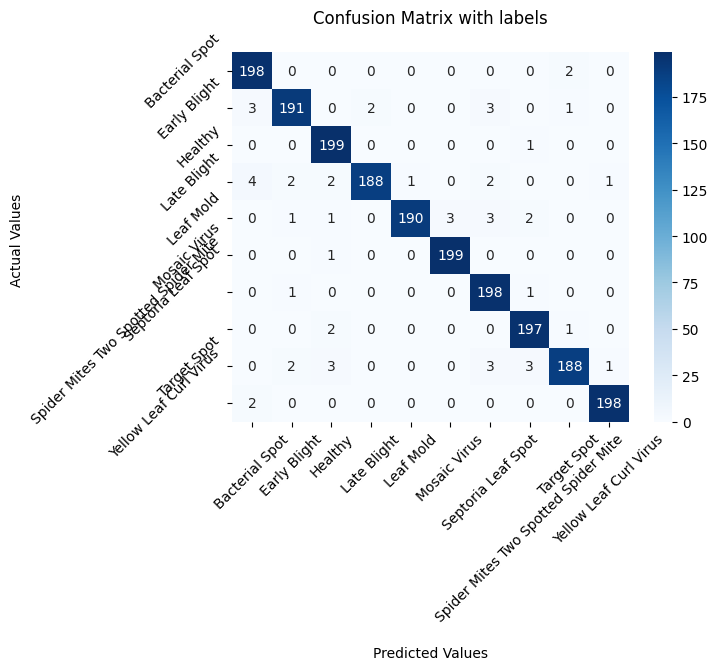

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)


ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

plt.show()

In [ ]:
def normalize_image(image):
    height, width, _ = image.shape
    norm_size = max(height, width)
    add_h = norm_size - height
    add_w = norm_size - width
    start_add_h = add_h // 2
    start_add_w = add_w // 2
    new_img = np.full((norm_size, norm_size, 3), 255, dtype=np.uint8)
    new_img[start_add_h:start_add_h + height, start_add_w:start_add_w + width, :] = image
    return new_img

def preprocessing(image):
  img = normalize_image(image)
  img = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
  return np.array(img)

In [11]:
new_model = tf.keras.models.load_model('/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Tomato/Model2/Densenet121-0.97val')

In [12]:
new_model.save('/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Tomato/Model2/Tomato_Densenet121-0.97val.h5')

1/1 [==============================] - 0s 35ms/step


'Leaf Mold'

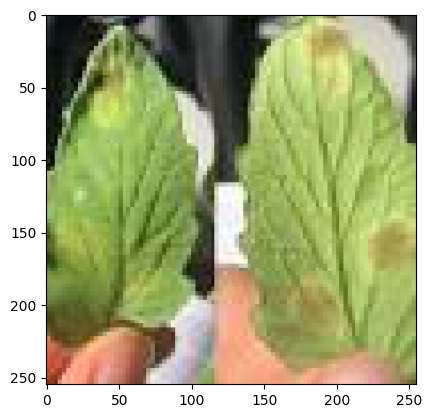

In [ ]:
predict_new_data(new_model, (255,255), '/content/drive/MyDrive/Capstone/Tomato/Test/tomato leaf mold.jpg')

In [ ]:
save_model("Densenet121-0.97val", model1, "/content/drive/MyDrive/Capstone/Tomato/Model")

Export path:  /content/drive/MyDrive/Capstone/Tomato/Model/Densenet121-0.97val
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/Tomato/Model/Densenet121-0.97val')